In [65]:
import numpy as np
from tqdm import tqdm
%matplotlib inline
import os
from torch.nn import functional as F
from torch import nn
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [73]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
img = d2l.plt.imread('d2l-zh-master/img/catdog.jpg')
h, w = img.shape[:2]
h, w
img.shape

(561, 728, 3)

In [5]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel.

    Defined in :numref:`sec_anchor`"""
    in_height, in_width = data.shape[-2:]
    # print(in_height,in_width)
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = d2l.tensor(sizes, device=device)
    ratio_tensor = d2l.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [6]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])  #找锚框
    print(anchors.shape)
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)

D:\ProgramData\Anaconda3\envs\leetcode38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 48, 4])


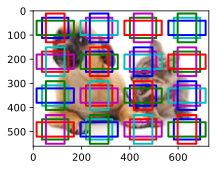

In [7]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])  #总共16个点，每个点3个锚框

torch.Size([1, 12, 4])


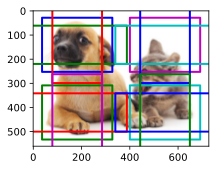

In [8]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

torch.Size([1, 3, 4])


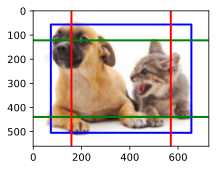

In [9]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

In [10]:
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [11]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
    else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
            'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [14]:
is_train = False
data_dir = d2l.download_extract('banana-detection')
csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
else 'bananas_val', 'label.csv')
csv_data = pd.read_csv(csv_fname)
csv_data = csv_data.set_index('img_name')
images, targets = [], []
for img_name, target in csv_data.iterrows():
    images.append(torchvision.io.read_image(
        os.path.join(data_dir, 'bananas_train' if is_train else
        'bananas_val', 'images', f'{img_name}')))
    # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
    # 其中所有图像都具有相同的香蕉类（索引为0）
    targets.append(list(target))
# return images, torch.tensor(targets).unsqueeze(1) / 256

In [18]:
torch.tensor(targets).shape

torch.Size([1000, 5])

In [19]:
torch.tensor(targets).unsqueeze(1).shape

torch.Size([1000, 1, 5])

In [21]:
torch.tensor(targets).unsqueeze(1)

tensor([[[  0, 104,  20, 143,  58]],

        [[  0,  68, 175, 118, 223]],

        [[  0, 163, 173, 218, 239]],

        ...,

        [[  0,  47,  54,  86, 109]],

        [[  0,  43, 125,  90, 166]],

        [[  0, 191,  99, 249, 152]]])

In [22]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""

    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
                                                   is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [24]:
bset = BananasDataset(True)

read 1000 training examples


In [31]:
bset[1][1].shape

torch.Size([1, 5])

In [26]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [27]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

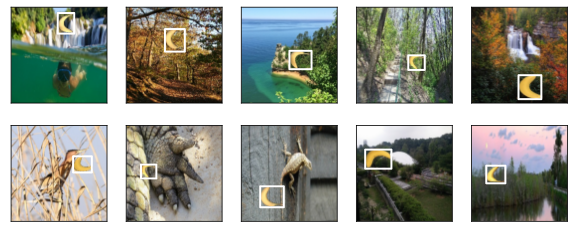

In [33]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 256
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

In [36]:
def cls_predictor(num_inputs, num_anchors, num_classes):  #输入输出不变
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)


def bbox_predictor(num_inputs, num_anchors):  #4个偏移量，左上右下
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [37]:
def forward(x, block):
    return block(x)


Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [39]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)


def concat_preds(preds):  #连接多个block的输出
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [40]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [41]:
55 * 400 + 33 * 100

25300

In [42]:
#高宽减半块
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [43]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [45]:
#基本网络块
#通道翻倍，长宽减半
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)


forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### 完整块
完整的单发多框检测模型由五个模块组成。每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。从技术上讲，第二到第五个区块都是 图13.7.1中的多尺度特征块。

In [46]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [47]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [48]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [49]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

我们创建一个模型实例，然后使用它对一个\(256 \times 256\)像素的小批量图像X执行前向传播。

如本节前面部分所示，第一个模块输出特征图的形状为\(32 \times 32\)。 回想一下，第二到第四个模块为高和宽减半块，第五个模块为全局汇聚层。 由于以特征图的每个单元为中心有\(4\)个锚框生成，因此在所有五个尺度下，每个图像总共生成\((32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444\)个锚框。锚框与批量数无关。
cls_preds为每个批量，每个锚框，每个预测值的情况
bbox_preds为每个批量，每个锚框*4的偏置量

In [51]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [52]:
device, net = 'cuda', TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [53]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')


def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [54]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())


def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [59]:
num_epochs = 20
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = np.array([0., 0., 0., 0.])
    net.train()
    for features, target in tqdm(train_iter):
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric += np.array([cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                            bbox_labels.numel()])
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    print(f'{epoch + 1=}', f'{cls_err=}, {bbox_mae=}')
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')

100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


epoch + 1=1 cls_err=0.0052351212343865194, bbox_mae=0.00535896505878569


100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


epoch + 1=2 cls_err=0.004853416605437144, bbox_mae=0.005063800436183865


100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


epoch + 1=3 cls_err=0.00479298310066123, bbox_mae=0.0048246173956742805


100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


epoch + 1=4 cls_err=0.0045341660543717355, bbox_mae=0.00454716552241071


100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


epoch + 1=5 cls_err=0.004229610580455567, bbox_mae=0.004326121978423422


100%|██████████| 32/32 [00:10<00:00,  3.06it/s]


epoch + 1=6 cls_err=0.004014878765613572, bbox_mae=0.0041942235622924534


100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


epoch + 1=7 cls_err=0.003783431300514284, bbox_mae=0.004073652095079948


100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


epoch + 1=8 cls_err=0.0037869213813372937, bbox_mae=0.003957068668228138


100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


epoch + 1=9 cls_err=0.0036653196179280423, bbox_mae=0.0038308924157158756


100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


epoch + 1=10 cls_err=0.0036061719324026464, bbox_mae=0.003715367420204942


100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


epoch + 1=11 cls_err=0.003591844232182173, bbox_mae=0.0036089711269852347


100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


epoch + 1=12 cls_err=0.003484753857457723, bbox_mae=0.0035152839755941893


100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


epoch + 1=13 cls_err=0.003455363703159464, bbox_mae=0.003433528830074896


100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


epoch + 1=14 cls_err=0.003463445995591452, bbox_mae=0.0033550859517161237


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


epoch + 1=15 cls_err=0.0033747244673034693, bbox_mae=0.003291610880339522


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


epoch + 1=16 cls_err=0.0033379867744305347, bbox_mae=0.003235298260444232


100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


epoch + 1=17 cls_err=0.003301065393093272, bbox_mae=0.0031789428968800946


100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


epoch + 1=18 cls_err=0.0032555106539309264, bbox_mae=0.0031424214659500965


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


epoch + 1=19 cls_err=0.003253673769287313, bbox_mae=0.003095266968603085


100%|██████████| 32/32 [00:10<00:00,  3.18it/s]

epoch + 1=20 cls_err=0.003206282145481243, bbox_mae=0.003059206612928224
class err 3.21e-03, bbox mae 3.06e-03


In [60]:
X = torchvision.io.read_image('d2l-zh-master/img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [62]:
X.shape

torch.Size([1, 3, 256, 256])

In [64]:
img.shape

torch.Size([256, 256, 3])

In [69]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    print(cls_preds.shape)
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    print(cls_probs.shape)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    print(output.shape)
    print(output[0].shape)
    # print(output[1].shape)
    # print(output[2].shape)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

torch.Size([1, 5444, 2])
torch.Size([1, 2, 5444])
torch.Size([1, 5444, 6])
torch.Size([5444, 6])


In [70]:
output

tensor([[ 0.0000,  0.9994,  0.4367,  0.5808,  0.6558,  0.7858],
        [ 0.0000,  0.9986,  0.0935,  0.7586,  0.2895,  0.9535],
        [ 0.0000,  0.9925,  0.7056,  0.3658,  0.8945,  0.5693],
        [ 0.0000,  0.9853,  0.5455,  0.0574,  0.7484,  0.2669],
        [ 0.0000,  0.5164,  0.4727,  0.5415,  0.6874,  0.7207],
        [ 0.0000,  0.3496,  0.4995,  0.1032,  0.6983,  0.2887],
        [ 0.0000,  0.2417,  0.3959,  0.4820,  0.6244,  0.7259],
        [ 0.0000,  0.2043,  0.4675,  0.0163,  0.7101,  0.2607],
        [ 0.0000,  0.1811,  0.0653,  0.7082,  0.2583,  0.8961],
        [ 0.0000,  0.1694,  0.3896,  0.5984,  0.6105,  0.7441],
        [ 0.0000,  0.1503,  0.5980,  0.1016,  0.8293,  0.3108],
        [ 0.0000,  0.1340,  0.6877,  0.2909,  0.8985,  0.4877],
        [ 0.0000,  0.1049,  0.0852,  0.8190,  0.3162,  0.9986],
        [ 0.0000,  0.1013,  0.5089,  0.6156,  0.7258,  0.7997],
        [ 0.0000,  0.0944,  0.4396,  0.4503,  0.6493,  0.6587],
        [ 0.0000,  0.0885,  0.4732,  0.6

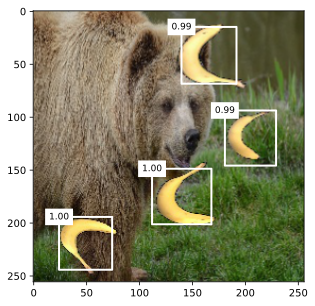

In [71]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

In [72]:
w,h

(728, 561)